## Playing around with flows

This notebook shows some first steps using flows.

In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

(1000, 2)

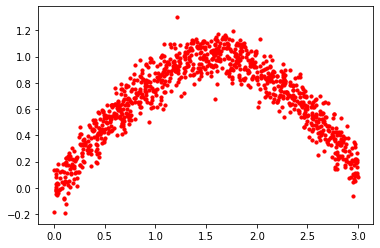

In [53]:
DTYPE=tf.float32
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 1000

def makeData(n_samples):
#     noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=42)
#     X, _ = noisy_moons
#     X = StandardScaler().fit_transform(X)

    X1 = np.random.uniform(0,3,n_samples)
    X2 = np.sin(X1) + np.random.normal(0,0.1,n_samples)
    X = np.vstack((X1,X2)).T
    X = np.array(X, dtype='float32')
    return X

X = makeData(n_samples)   
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
X.shape

We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`.

In [54]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class MAF(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        self.shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(
            hidden_layers=[512, 512])        # Defining the bijector
        num_bijectors = 4
        bijectors=[]
        for i in range(num_bijectors):
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=self.shift_and_log_scale_fn))
            bijectors.append(tfb.Permute(permutation=[1, 0]))
        # Discard the last Permute layer.
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        # Defining the flow
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=bijector)

    def call(self, *inputs): #inputs is a list or 
        #_ = self.flow.bijector.forward(*inputs) #Need to be called to "build" the graph
        #return self.flow #Needs to be outputted to later access the Transformed distribution
        return self.flow.bijector.forward(*inputs)
    
    def getFlow(self, num):
        return self.flow.sample(num)

print(X.shape)
model = MAF(output_dim=2, num_masked=1)
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
model.summary()

(1000, 2)
Model: "maf_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 266,244
Trainable params: 266,244
Non-trainable params: 0
_________________________________________________________________


In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function #Adding the tf.function makes it about 10 times faster!!!
def train_step(X):
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

0   0.6177458 0.03506970405578613


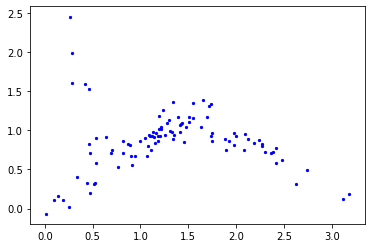

50   0.72946465 1.1508066654205322
100   0.6113794 0.9378097057342529
150   0.78533834 0.9229567050933838
200   0.69161856 0.9275696277618408
250   0.6985788 0.9201364517211914
300   0.7445887 0.9887456893920898
350   0.7411807 0.934725284576416
400   0.7559019 0.9777662754058838
450   0.6979367 0.9679450988769531
500   0.7895513 0.9143803119659424
550   1.2899504 0.9398636817932129
600   0.8056587 1.029780387878418
650   0.855181 0.9447722434997559
700   0.761386 0.9810061454772949
750   0.95291245 0.9349863529205322
800   0.52370334 0.9250445365905762
850   0.7354379 0.9239416122436523
900   0.78309286 0.9240458011627197
950   0.72531265 0.9186325073242188
1000   0.6627995 0.931922435760498


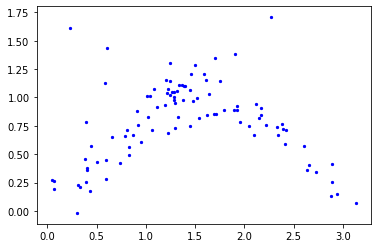

1050   0.8339695 1.2021639347076416
1100   0.6838823 1.0599093437194824
1150   0.79888153 1.0681500434875488
1200   0.68165153 1.0957012176513672
1250   0.72311205 1.159299373626709
1300   0.7679623 1.132244348526001
1350   0.7662075 1.0380043983459473
1400   0.80467725 1.09071946144104
1450   0.7365117 1.0116615295410156
1500   0.61684453 1.0031251907348633
1550   0.625681 0.9897871017456055
1600   0.7277914 1.0255787372589111
1650   0.671818 0.9353189468383789
1700   0.8642663 0.9594392776489258
1750   0.6302102 0.9483168125152588
1800   0.836492 0.9178853034973145
1850   0.70543647 1.0023045539855957
1900   0.72041506 0.9641678333282471
1950   0.7628765 1.0121955871582031
2000   0.71518403 0.9286549091339111


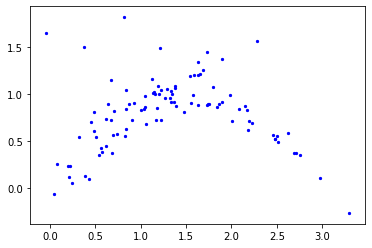

2050   0.77053255 1.1744844913482666
2100   0.7604271 0.9591336250305176
2150   0.81708634 0.9315991401672363
2200   0.61446345 0.9867315292358398
2250   0.82495797 0.9307327270507812
2300   0.7521038 0.9346270561218262
2350   0.63545823 1.0160143375396729
2400   0.8378133 1.080409049987793
2450   0.60359395 1.0401654243469238
2500   0.8050543 0.9369344711303711
2550   0.8790858 0.9206957817077637
2600   0.7004904 0.9413361549377441
2650   0.6691463 0.9373862743377686
2700   1.0507091 0.9453325271606445
2750   0.6233322 0.9758844375610352
2800   0.59585476 0.920219898223877
2850   0.7161083 0.9295687675476074
2900   0.77815545 0.934546947479248
2950   0.93014175 0.9788210391998291
3000   0.7583654 1.0035159587860107


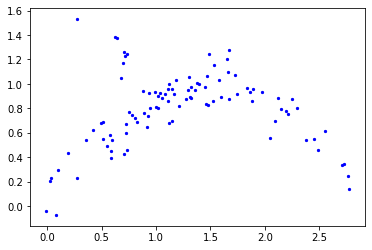

3050   0.8004292 1.1958105564117432
3100   0.6780572 1.0417931079864502
3150   0.7436441 0.9911551475524902
3200   0.68305093 0.9931623935699463
3250   0.76439667 1.026573657989502
3300   0.7506408 1.011418104171753
3350   0.68502545 0.9878566265106201
3400   0.8736085 1.0152904987335205
3450   0.7859794 1.0402123928070068
3500   0.6601942 0.9527325630187988
3550   0.7016457 1.01479172706604
3600   1.3104521 0.9886212348937988
3650   0.56286144 0.9462604522705078
3700   0.44159278 0.9560079574584961
3750   0.6706088 0.9356751441955566
3800   0.6570528 1.0115058422088623
3850   0.48390353 0.9744923114776611
3900   0.6306172 1.0219089984893799
3950   0.79945695 0.9804537296295166
4000   1.1453422 1.024451494216919


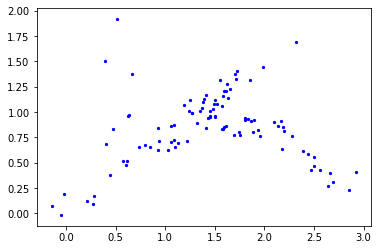

4050   0.74860144 1.2272796630859375
4100   0.69409513 1.0160212516784668
4150   0.67481923 1.047837495803833
4200   0.6121702 1.023946762084961
4250   0.69106513 1.031616449356079
4300   0.71243775 1.0402061939239502
4350   0.65908885 1.0728766918182373
4400   0.64643914 1.0423614978790283
4450   0.6433994 1.0169305801391602
4500   0.9096761 1.0387394428253174
4550   0.7388169 1.074280023574829
4600   0.7086038 1.0388123989105225
4650   0.7383057 1.0431697368621826
4700   0.50930583 1.0559353828430176
4750   0.77218735 1.0058274269104004
4800   0.4398584 1.0896308422088623
4850   1.1236666 1.0228667259216309
4900   0.6716629 0.9898293018341064
4950   0.6356156 1.0897045135498047
5000   0.53606933 1.0995726585388184


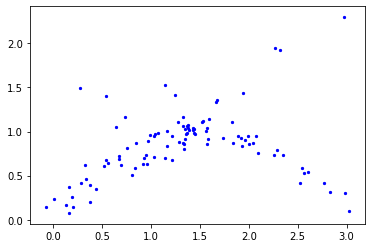

In [59]:
from time import time
start = time()
for i in range(5001):
    loss = train_step(makeData(100))
    if (i % 50 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()
    if (i % 1000 == 0):   
        XF = model.flow.sample(100) 
        plt.scatter(XF[:, 0], XF[:, 1], s=5, color='blue')
        plt.show()

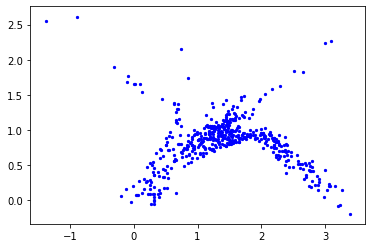

In [63]:
XF = model.flow.sample(500) 
plt.scatter(XF[:, 0], XF[:, 1], s=5, color='blue')